# 6. 알고리즘 체인과 파이프라인

In [1]:
import os
import sys
if 'google.colab' in sys.modules and not os.path.isdir('mglearn'):
    # 사이킷런 최신 버전을 설치합니다.
    !pip install -q --upgrade scikit-learn
    # mglearn을 다운받고 압축을 풉니다.
    !wget -q -O mglearn.tar.gz https://bit.ly/mglearn-tar-gz
    !tar -xzf mglearn.tar.gz
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    fm._rebuild()

In [10]:
import sklearn
import matplotlib
import mglearn

# 나눔 폰트를 사용합니다.
matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:

from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다
scaler = MinMaxScaler().fit(X_train)

In [5]:
# 훈련 데이터의 스케일을 조정합니다
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.97


### 6.1 데이터 전처리와 매개변수 선택

In [7]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


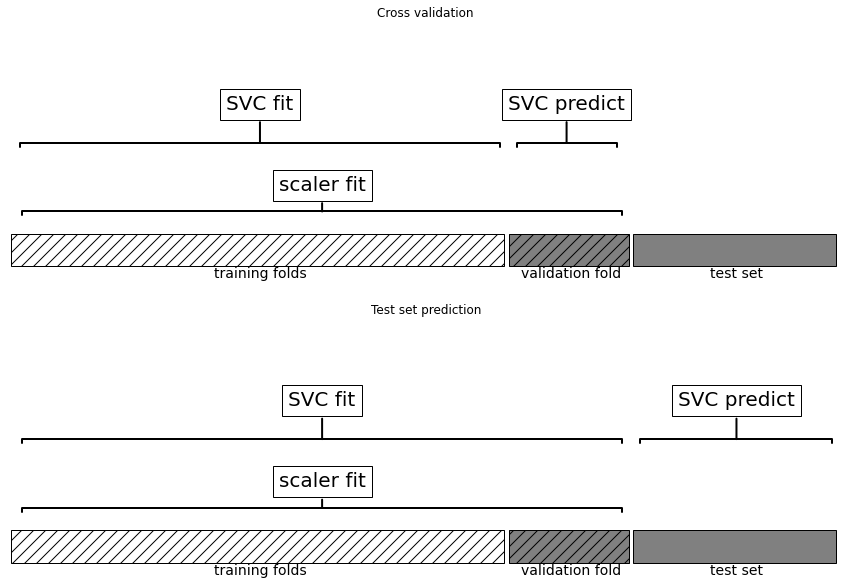

In [11]:
mglearn.plots.plot_improper_processing()

### 6.2 파이프라인 구축하기

In [13]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [15]:
pipe.fit(X_train, y_train) # 파이프라인에서 fit메서드 호출

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [16]:
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.97


### 6.3 그리드 서치에 파이프라인 적용하기

In [17]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [18]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수:", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


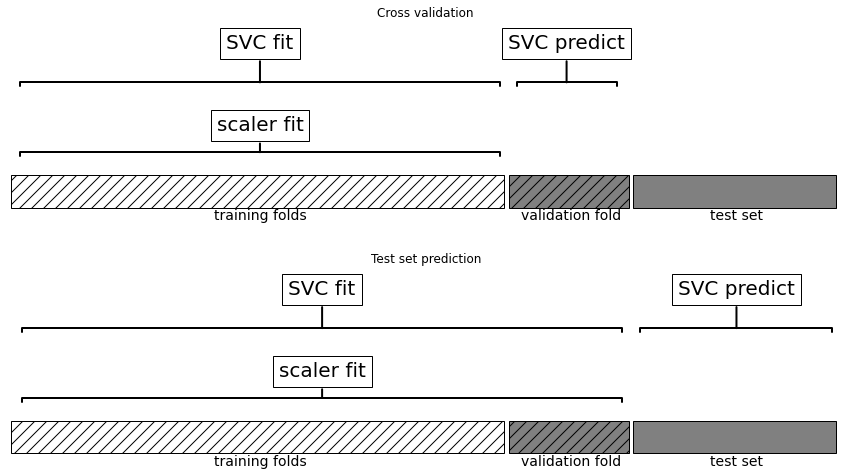

In [19]:

mglearn.plots.plot_proper_processing()

### 6.4 파이프라인 인터페이스

In [20]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [21]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다
    return self.steps[-1][1].predict(X_transformed)

### 6.4.1 make_pipleline을 사용한 파이프라인 생성

In [22]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))

In [23]:
print("파이프라인 단계:\n", pipe_short.steps)


파이프라인 단계:
 [('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=100))]


In [24]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n", pipe.steps)

파이프라인 단계:
 [('standardscaler-1', StandardScaler()), ('pca', PCA(n_components=2)), ('standardscaler-2', StandardScaler())]


- 파이프라인을 만드는게 번거롭기에 이름을 부여하지 않아도 될 경우엔 위처럼 make_pipeline함수사용
- 더 의미있는 이름을 붙이려면 pipeline으로 객체를 직접 만드는것이 좋을때도 있다.

### 6.4.2 단계 속성에 접근하기

In [25]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps["pca"].components_
print("components.shape:", components.shape)

components.shape: (2, 30)


### 6.4.3 그리드 서치 안의 파이프라인의 속성에 접근하기
Grid search (격자 탐색) 은 모델 하이퍼 파라미터에 넣을 수 있는 값들을  
순차적으로 입력한뒤에 가장 높은 성능을 보이는 하이퍼 파라미터들을 찾는 탐색 방법이다. 

 

In [26]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

In [27]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [29]:
print("최상의 모델:\n", grid.best_estimator_)

최상의 모델:
 Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1, max_iter=1000))])


In [30]:

print("로지스틱 회귀 단계:\n",
      grid.best_estimator_.named_steps["logisticregression"])

로지스틱 회귀 단계:
 LogisticRegression(C=1, max_iter=1000)


In [31]:
print("로지스틱 회귀 계수:\n",
      grid.best_estimator_.named_steps["logisticregression"].coef_)

로지스틱 회귀 계수:
 [[-0.43570655 -0.34266946 -0.40809443 -0.5344574  -0.14971847  0.61034122
  -0.72634347 -0.78538827  0.03886087  0.27497198 -1.29780109  0.04926005
  -0.67336941 -0.93447426 -0.13939555  0.45032641 -0.13009864 -0.10144273
   0.43432027  0.71596578 -1.09068862 -1.09463976 -0.85183755 -1.06406198
  -0.74316099  0.07252425 -0.82323903 -0.65321239 -0.64379499 -0.42026013]]


### 6.5 전처리와 모델의 매개변수를 위한 그리드 서치
- 파이프라인을 사용하면 머신러닝 워크플로에 필요한 모든 처리단계를 하나의 scikit-learn 추정기로 캡슐화 할 수 있다.

### 6.6 모델 선택을 위한 그리드 서치
- GridSearchCV와 Pipieline을 연결하는 것에서 더 나아가 파이프라인을 구성하는 단계도 탐색 대상으로 삼을 수 있다.  
- 모든 알고리즘을 시도해보는 것이 필수적인 머신러닝 전략은 아니다.

In [40]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])


In [41]:

from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier': SVC(C=10, gamma=0.01), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


### 6.6.1 중복 계산 피하기

In [44]:

pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())],
                memory="cache_folder")

- 요약 및 정리
머신러닝 애플리케이션은 모델을 단독으로 사용하는 경우가 거의 없으며 여러 처리단계가 연속해서 이뤄진다. 
파이프라인을 사용하면 여러 단계를 하나의 파이썬 객체로 캡슐화해주고 싸이킷럿의 fit predict transform 인터페이스를 사용할 수 있다.  
특성 추출, 전처리, 모델의 완벽한 조합을 찾는 것은 예술에 가까운 일이라 어느정도 시행착오가 필요하다. 하지만 파이프라인을 사용하면 여러 다른 처리 단계를 손쉽게 시도해볼 수 있다.